<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


Cloning into 'face_detection'...
remote: Enumerating objects: 5010, done.
remote: Counting objects: 100% (5010/5010), done.
remote: Compressing objects: 100% (5008/5008), done.
remote: Total 5010 (delta 1), reused 5003 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5010/5010), 32.47 MiB | 11.96 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/face_detection/face_detection


In [66]:
#LIBRERIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model




In [28]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,male,70,111,107,111,37
1,1.jpg,male,71,110,106,111,31
2,2.jpg,male,71,111,106,110,37
3,3.jpg,male,68,111,108,112,51
4,4.jpg,male,71,111,106,110,36


In [32]:
print(data.describe())

            gender  left_eye_x  left_eye_y  right_eye_x  right_eye_y  \
count  5000.000000  5000.00000  5000.00000   5000.00000  5000.000000   
mean      0.423200    69.39320   111.18780    107.60540   111.144200   
std       0.494116     1.73931     1.12338      1.70689     1.179866   
min       0.000000    60.00000   104.00000     93.00000   100.000000   
25%       0.000000    68.00000   111.00000    107.00000   111.000000   
50%       0.000000    69.00000   111.00000    108.00000   111.000000   
75%       1.000000    70.00000   112.00000    109.00000   112.000000   
max       1.000000    86.00000   117.00000    114.00000   122.000000   

               age  
count  5000.000000  
mean     37.074200  
std       8.533819  
min      11.000000  
25%      32.000000  
50%      35.000000  
75%      40.000000  
max      77.000000  


In [30]:
#Conertimos la columan de male, female a binario

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


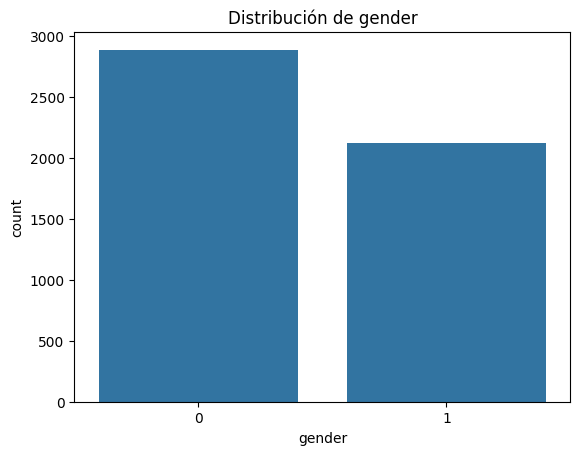

In [34]:
 #Ahora analizaremos cada variable
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

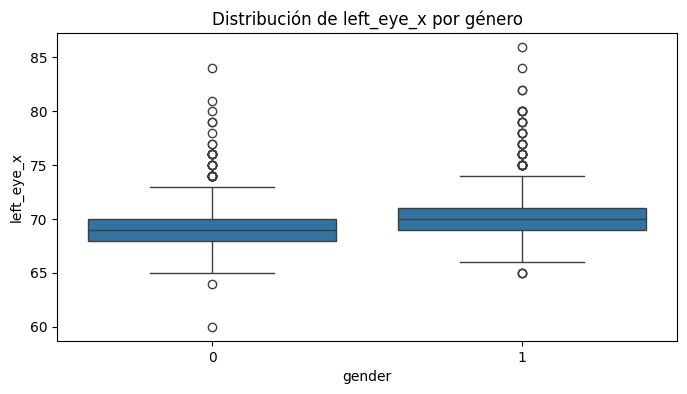

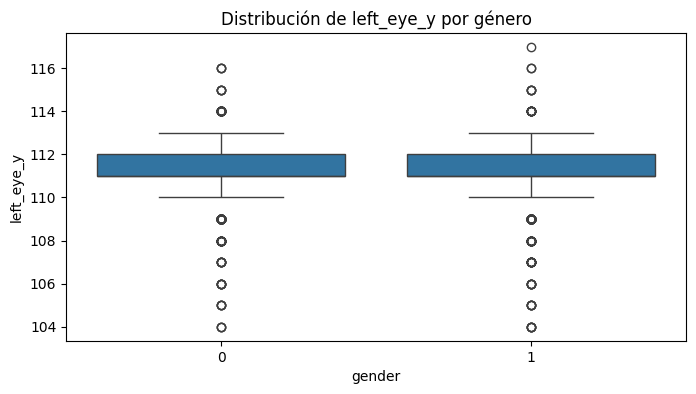

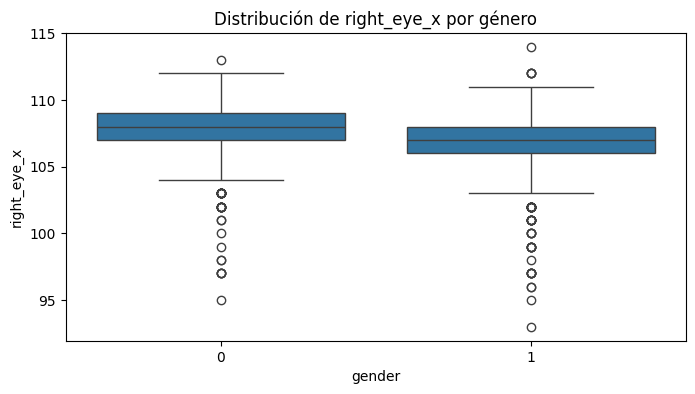

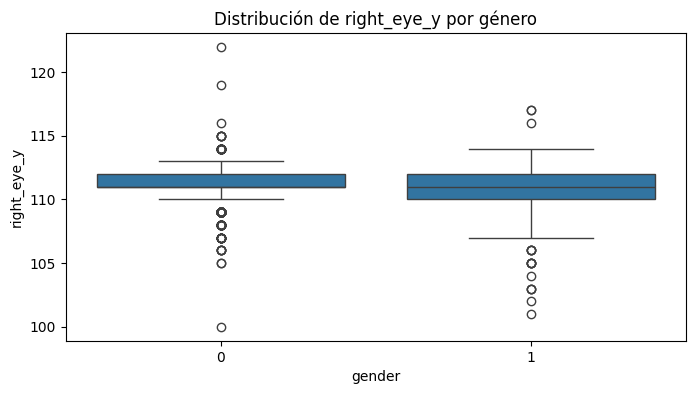

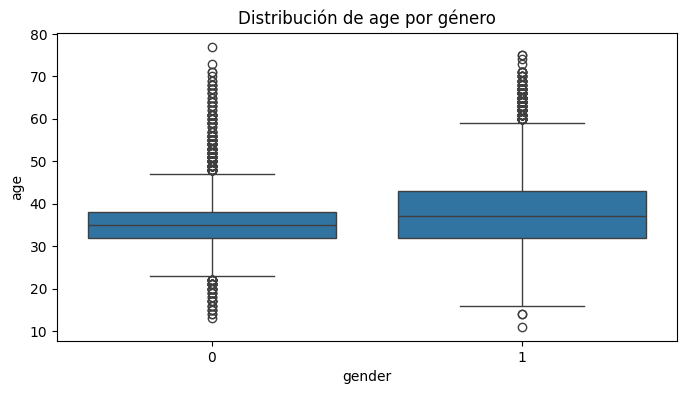

In [35]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Tenemos resultados muy diferentes, lo que tiene sentido pq la persona puede estar desplazada...

In [61]:
#DIVIDIMOS EL DATASET EN TRAIN, TEST, VALIDATE

# Paso 1: dividir primero en train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data['gender'],
    random_state=42
)

# Paso 2: dividir temp en val y test (mitad y mitad)
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.5,
    stratify=data['gender'],
    random_state=42
)


,gender
1304,1
4676,1
2197,1
2453,0
2941,1


In [63]:
### Relacionar datos con imagenes para preparar el input del modelo

# Función para cargar y procesar la imagen
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # normaliza [0,1]
    # Aquí NO cambiamos tamaño para mantener 178x218 original
    return image

# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes):
    for i in range(len(images)):
        img = load_and_preprocess_image(images.iloc[i])  # usa .iloc si son pandas Series
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values  # ojo que eyes es DataFrame, pasamos a array
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels

def create_tf_dataset(images, genders, ages, eyes):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes),
        output_signature=(
            tf.TensorSpec(shape=(218, 178, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO
#BATCH_SIZE = 32

#train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    print(label)
    pass  # solo itera, el print ya está en load_and_preprocess_image




{'gender': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'age': <tf.Tensor: shape=(), dtype=float32, numpy=35.0>, 'eye_pos': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 71., 110., 106., 111.], dtype=float32)>}
{'gender': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'age': <tf.Tensor: shape=(), dtype=float32, numpy=34.0>, 'eye_pos': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 68., 113., 109., 111.], dtype=float32)>}
{'gender': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'age': <tf.Tensor: shape=(), dtype=float32, numpy=46.0>, 'eye_pos': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 67., 111., 109., 113.], dtype=float32)>}
{'gender': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'age': <tf.Tensor: shape=(), dtype=float32, numpy=29.0>, 'eye_pos': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 68., 111., 109., 112.], dtype=float32)>}
{'gender': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'age': <tf.Tensor: shape=(), dtype=float32, numpy=31

In [68]:
# Input layer
input_img = Input(shape=(218, 178, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-68-426db0a79023>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [69]:
#ENTRENAMOS EL MODELO

history = model.fit(
    train_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    validation_data=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    epochs=10
)

model.evaluate(test_dataset.batch(32))




Epoch 1/10


KeyboardInterrupt: 